# MSE PySupport HACKATHON NOTEBOOK - Team LumberHacks

# 1. **Importing the libraries:**

In [5]:
path = '../input/mse-pysupport-hackathon/simulation.csv'
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
#from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv(path, parse_dates = [1])
df.head()

,SalePrice,SaleDate,SaleDeed,ArmsLengthTransaction,EstimateLand,EstimateBuilding,MostRecentSale,Pin,PropertyAddress,NeighborhoodCode,...,RepairCondition,GarageIndicator,Garage1Size,Garage1Material,Garage1Attachment,Garage1Area,Garage2Size,Garage2Material,Garage2Attachment,Garage2Area
0,407000,2013-09-17,1326022056,1,55800,80200,1.0,13013260100000,5627 N RICHMOND ST,42,...,Avg,1.0,3.0,Wood,No,No,7.0,Other,Other,Other1
1,1,2017-05-08,1712801037,0,30620,34480,1.0,14061120241008,6116 N CLAREMONT AVE,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,340000,2013-07-17,1319841023,1,8490,253800,0.0,14213140481165,3200 N LAKE SHORE DR,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89000,2018-06-29,1818057130,1,23760,124690,1.0,24362310030000,2449 NEW ST,132,...,Avg,1.0,3.0,Wood,No,No,7.0,Other,Other,Other1
4,375000,2014-09-24,1426755105,1,59850,253540,1.0,16081150120000,229 N TAYLOR AVE,90,...,Avg,1.0,3.0,Wood,No,No,7.0,Other,Other,Other1


In [7]:
#Dropping all Non-ArmsLengthTransactions. Go through the accompanying notebook to read more about it.
df.drop(df[df['ArmsLengthTransaction'] == 0].index, inplace = True)

In [8]:
df['Pin'] = df['Pin'].astype(str)

df['AreaCode'] = df['Pin'].str[:2]
df['AreaSubCode'] = df['Pin'].str[2:4]

df['Sale_Year'] = pd.DatetimeIndex(df['SaleDate']).year
df['Sale_Month'] = pd.DatetimeIndex(df['SaleDate']).month
df['Sale_Week'] = pd.DatetimeIndex(df['SaleDate']).week

In [9]:
# REPLACING NaN IN "OHareNoise", "FloodPlain" & "RoadProximity" with group modes according to Township.

gmode = ['OHareNoise', 'Floodplain', 'RoadProximity']
for col in gmode:
    df[col] = df.groupby(['TownshipName'])[col].apply(lambda x: x.fillna(x.mode()[0]))
    #df[col] = df.groupby(['AreaCode'])[col].apply(lambda x: x.fillna(x.mode()[0]))#,'AreaSubCode'
    

In [10]:
#Splitting dataset into condominimum and non-condominiums
df_apt = df[df['PropertyDesc'] != 'Residential condominium']
df_cond = df[df['PropertyDesc'] == 'Residential condominium']

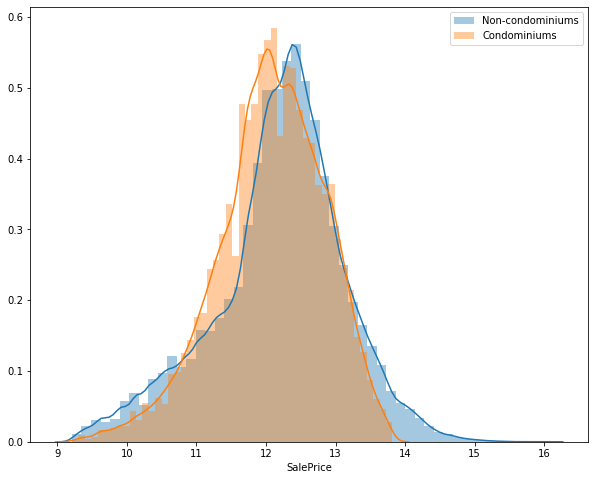

In [11]:
fig = plt.figure(figsize=(10,8))

sns.distplot(np.log1p(df_apt['SalePrice']), label = 'Non-condominiums')
sns.distplot(np.log1p(df_cond['SalePrice']), label = 'Condominiums')

plt.legend();
plt.show();

In [12]:
df['CathedralCeiling'].value_counts()

None       124580
Partial     97396
Full         8784
Name: CathedralCeiling, dtype: int64

In [13]:
apt_feat = ['MultiPropertyIndicator','MultiFamilyIndicator','PropertyDesc','Porch','EstimateLand','Renovation','LandSquareFeet',
            'Rooms','OtherImprovements','EstimateBuilding','BuildingSquareFeet','Bedrooms','RepairCondition','AtticFinish','MostRecentSale',
            'OHareNoise','FullBaths','GarageIndicator','Garage2Area','Floodplain','HalfBaths','BasementFinish','RoadProximity','CentralAir',
            'WallMaterial','TypeOfResidence','DesignPlan','SiteDesirability','Apartments','Age','ConstructionQuality','Garage1Size',
            'Garage1Area','Garage1Material','Garage1Attachment', 'CentralHeating', 'OtherHeating', 'CentralAir', 'Fireplaces','NeighborhoodCode',
            'TownshipLocation','AtticType','AreaCode','Basement', 'Sale_Year', 'Sale_Month','MultiCode','CathedralCeiling','RoofMaterial','Sale_Week']

cond_feat = ['EstimateLand','EstimateBuilding','MultiPropertyIndicator','MultiFamilyIndicator','MostRecentSale','OHareNoise','Floodplain',
             'CondoNumberOfUnits','RoadProximity','CondoPercentOwnership','Age', 'NeighborhoodCode','TownshipLocation','AreaCode','Sale_Year',
             'Sale_Month','Sale_Week']#,'CondoStrata']

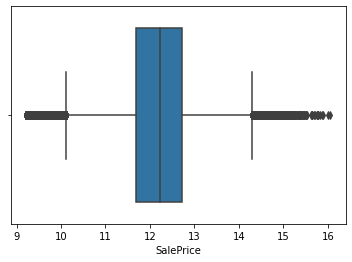

In [39]:
sns.boxplot(x = np.log(df['SalePrice']))

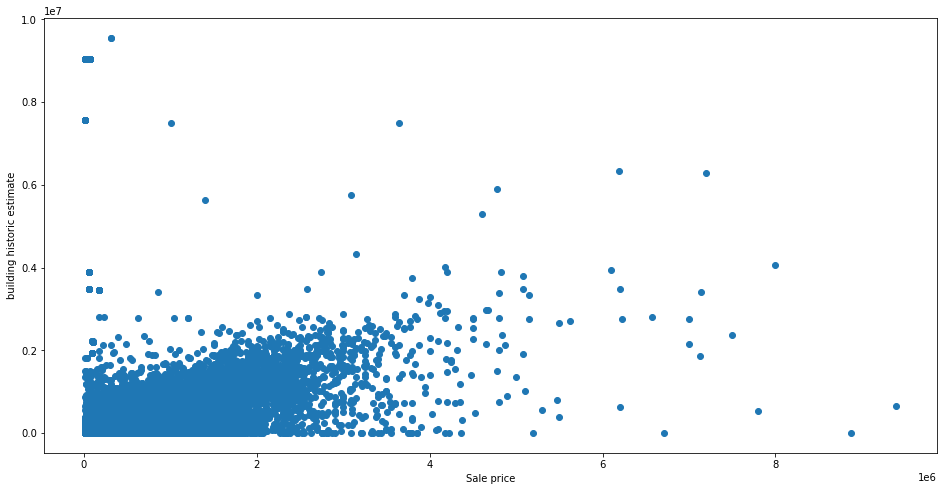

In [40]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['SalePrice'],df['EstimateBuilding'])
ax.set_xlabel('Sale price')
ax.set_ylabel('building historic estimate')
plt.show()

# 2. Feature engineering

* ### **Missing values identification and imputation**

## 2.A. Non-Condominium features

In [14]:
pd.options.mode.chained_assignment = None #To suppress overwrite warnings 

In [15]:
#FILL MISSING VALUES:

#Renovation
df_apt['Renovation'] = df_apt['Renovation'].fillna("No")
df_apt['Renovation'] = df_apt['Renovation'].map({'Yes':1,'No':0})

# ATTIC TYPE
df_apt.loc[df_apt['AtticType'] == 'None', 'AtticFinish'] = "Unfinished"  #SET ALL WITH NO ATTIC AS UNFINISHED
df_apt['AtticFinish'].fillna("Unfinished", inplace = True) #SET ALL STILL BLANK ATTICFINISH AS UNFINISHED
df_apt['AtticFinish'] = df_apt['AtticFinish'].apply(lambda x: 0 if x == 'Unfinished' else 1 )

df_apt['MostRecentSale'].fillna(1, inplace = True)

df_apt['Garage2Area'].fillna("Other1", inplace = True)
df_apt['Garage2Area'] = df_apt['Garage2Area'].apply(lambda x: 1 if x == 'Yes' else 0 )

df_apt['CentralHeating'].fillna("Warm Air", inplace = True)

df_apt['BasementFinish'].fillna(df_apt['BasementFinish'].mode()[0], inplace = True)

#Category converter:
c = ['PropertyDesc','CentralHeating','BasementFinish','NeighborhoodCode','TownshipLocation','AreaCode','Sale_Month','RoofMaterial','Sale_Week']

for col in c:
    df_apt[col] = df_apt[col].astype("category")


#Ordinal encoding:
df_apt['RepairCondition'] = df_apt['RepairCondition'].map({'AboveAvg':2, 'Avg':1, 'BelowAvg':0}) #Repair condition
df_apt['WallMaterial'] = df_apt['WallMaterial'].map({'Wood':0, 'Masonry':1, 'Wood&Masonry':2, 'Stucco':3}) #Wall material
df_apt['DesignPlan'] = df_apt['DesignPlan'].map({'None':0,'StockPlan':1, 'ArchitectPlan':2}) #Design Plan
df_apt['ConstructionQuality'] = df_apt['ConstructionQuality'].map({'Poor':0,'Average':1,"Deluxe":2}) #Construct quality
df_apt['Porch'] = df_apt['Porch'].map({'None':0,'Frame':1,'Masonry':2}) #Porch
df_apt['Garage1Material'] = df_apt['Garage1Material'].map({'Other':0,'Wood':1, 'Masonry':2, 'Wood&Masonry':3, 'Stucco':4}) #Construct quality
df_apt['Garage1Attachment'] = df_apt['Garage1Attachment'].apply(lambda x: 1 if x == 'Yes' else 0 )
df_apt['OtherHeating'] = df_apt['OtherHeating'].map({'None':0,'UnitHeater':1})
df_apt['Garage1Area'] = df_apt['Garage1Area'].apply(lambda x: 1 if x == 'Yes' else 0 )
df_apt['OtherImprovements'] = df_apt['OtherImprovements'].apply(lambda x: 1 if x != 0 else 0 )
df_apt['TypeOfResidence'] = df_apt['TypeOfResidence'].apply(lambda x: 1.65 if x > 4 else x) # else df_apt['TypeOfResidence'] )
df_apt['AtticType'] = df_apt['AtticType'].map({'None':0,'Partial':1,'Full':2})
df_apt['Basement'] = df_apt['Basement'].map({'Slab':0,'Crawl':1,'Partial':2,'Full':3 })
df_apt['CathedralCeiling'] = df_apt['CathedralCeiling'].map({'None':0,'Partial':1,'Full':2})


In [16]:
for col in apt_feat:
    print(col, ":", df_apt[col].dtype)

MultiPropertyIndicator : int64
MultiFamilyIndicator : int64
PropertyDesc : category
Porch : int64
EstimateLand : int64
Renovation : int64
LandSquareFeet : float64
Rooms : float64
OtherImprovements : int64
EstimateBuilding : int64
BuildingSquareFeet : float64
Bedrooms : float64
RepairCondition : int64
AtticFinish : int64
MostRecentSale : float64
OHareNoise : float64
FullBaths : float64
GarageIndicator : float64
Garage2Area : int64
Floodplain : float64
HalfBaths : float64
BasementFinish : category
RoadProximity : float64
CentralAir : float64
WallMaterial : int64
TypeOfResidence : float64
DesignPlan : int64
SiteDesirability : float64
Apartments : float64
Age : int64
ConstructionQuality : int64
Garage1Size : float64
Garage1Area : int64
Garage1Material : int64
Garage1Attachment : int64
CentralHeating : category
OtherHeating : int64
CentralAir : float64
Fireplaces : float64
NeighborhoodCode : category
TownshipLocation : category
AtticType : int64
AreaCode : category
Basement : int64
Sale_Yea

In [17]:
print("Missing values:")
for col in apt_feat:
    print(col," : " ,df_apt[col].isna().sum())

Missing values:
MultiPropertyIndicator  :  0
MultiFamilyIndicator  :  0
PropertyDesc  :  0
Porch  :  0
EstimateLand  :  0
Renovation  :  0
LandSquareFeet  :  0
Rooms  :  0
OtherImprovements  :  0
EstimateBuilding  :  0
BuildingSquareFeet  :  0
Bedrooms  :  0
RepairCondition  :  0
AtticFinish  :  0
MostRecentSale  :  0
OHareNoise  :  0
FullBaths  :  0
GarageIndicator  :  0
Garage2Area  :  0
Floodplain  :  0
HalfBaths  :  0
BasementFinish  :  0
RoadProximity  :  0
CentralAir  :  0
WallMaterial  :  0
TypeOfResidence  :  0
DesignPlan  :  0
SiteDesirability  :  0
Apartments  :  0
Age  :  0
ConstructionQuality  :  0
Garage1Size  :  0
Garage1Area  :  0
Garage1Material  :  0
Garage1Attachment  :  0
CentralHeating  :  0
OtherHeating  :  0
CentralAir  :  0
Fireplaces  :  0
NeighborhoodCode  :  0
TownshipLocation  :  0
AtticType  :  0
AreaCode  :  0
Basement  :  0
Sale_Year  :  0
Sale_Month  :  0
MultiCode  :  0
CathedralCeiling  :  0
RoofMaterial  :  0
Sale_Week  :  0


## 2.B. Condominium features

In [18]:
#Assuming that since no information about previous sale is given, the recorded sale must be the latest
df_cond['MostRecentSale'].fillna(1, inplace = True)
#df_cond['CondoStrata'].fillna(df_cond['CondoStrata'].mean(), inplace = True)

d = ['NeighborhoodCode','TownshipLocation','AreaCode','Sale_Month','Sale_Week']
for col in d:
    df_cond[col] = df_cond[col].astype("category")

In [19]:
for col in cond_feat:
    print(col, ":", df_cond[col].dtype)

EstimateLand : int64
EstimateBuilding : int64
MultiPropertyIndicator : int64
MultiFamilyIndicator : int64
MostRecentSale : float64
OHareNoise : float64
Floodplain : float64
CondoNumberOfUnits : float64
RoadProximity : float64
CondoPercentOwnership : float64
Age : int64
NeighborhoodCode : category
TownshipLocation : category
AreaCode : category
Sale_Year : int64
Sale_Month : category
Sale_Week : category


In [20]:
print("Missing values:")
for col in cond_feat:
    print(col," : " ,df_cond[col].isna().sum())

Missing values:
EstimateLand  :  0
EstimateBuilding  :  0
MultiPropertyIndicator  :  0
MultiFamilyIndicator  :  0
MostRecentSale  :  0
OHareNoise  :  0
Floodplain  :  0
CondoNumberOfUnits  :  0
RoadProximity  :  0
CondoPercentOwnership  :  0
Age  :  0
NeighborhoodCode  :  0
TownshipLocation  :  0
AreaCode  :  0
Sale_Year  :  0
Sale_Month  :  0
Sale_Week  :  0


# 3. Feature Selection and Model fitting

In [21]:
x1 = df_apt[apt_feat]
y1 = df_apt['SalePrice']

x2 = df_cond[cond_feat]
y2 = df_cond['SalePrice']

## 3.a. Model fit and R<sup>2</sup>

In [22]:
#Non-Condominium Housing Regression
model1  = LGBMRegressor()
model1.fit(x1, y1)

r2_score(y1, model1.predict(x1))

0.8783728979986285

In [23]:
#Condominium housing regression
model2  = LGBMRegressor()
model2.fit(x2, y2)

r2_score(y2, model2.predict(x2))

0.9168942426821005

# 4. Predicting on holdout data

In [24]:
# URL for Holdout data - https://www.kaggle.com/pranjalrawat/msepysupportholdout
path = '../input/mse-pysupport-hackathon/holdout.csv'
import pandas as pd
holdout = pd.read_csv(path)#, index_col = 'Id')
holdout.head()

,Id,SaleDate,SaleDeed,ArmsLengthTransaction,EstimateLand,EstimateBuilding,MostRecentSale,Pin,PropertyAddress,NeighborhoodCode,...,RepairCondition,GarageIndicator,Garage1Size,Garage1Material,Garage1Attachment,Garage1Area,Garage2Size,Garage2Material,Garage2Attachment,Garage2Area
0,72621,04/04/2013,1309422094,1,37500,239610,1.0,13094140190000,4958 W ARGYLE ST,60,...,Avg,0.0,0.0,Other,Other,Other1,7.0,Other,Other,Other1
1,11263,10/22/2019,1929541191,1,17520,102490,1.0,27231040261008,16147 CREEKMONT CT,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100878,11/27/2013,1333146014,1,30450,104790,1.0,33073200150000,19924 BROOK AVE,72,...,Avg,1.0,3.0,Masonry,No,No,7.0,Other,Other,Other1
3,198455,02/19/2014,1405035065,1,600,93840,0.0,17094180141074,182 W LAKE ST,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131760,08/06/2013,1321812174,1,69300,377170,0.0,3172040700000,714 E APPLETREE LN,40,...,Avg,1.0,3.0,Wood&Masonry,Yes,No,7.0,Other,Other,Other1


### HOLDOUT SET PRE-PROCESSING

In [25]:
holdout['Pin'] = holdout['Pin'].astype(str)

holdout['AreaCode'] = holdout['Pin'].str[:2]
holdout['AreaSubCode'] = holdout['Pin'].str[2:4]

holdout['Sale_Year'] = pd.DatetimeIndex(holdout['SaleDate']).year
holdout['Sale_Month'] = pd.DatetimeIndex(holdout['SaleDate']).month
holdout['Sale_Week'] = pd.DatetimeIndex(holdout['SaleDate']).week

In [26]:
# HOLDOUT SET: REPLACING NaN IN "OHareNoise", "FloodPlain" & "RoadProximity" with group modes according to Township.

gmode = ['OHareNoise', 'Floodplain', 'RoadProximity']
for col in gmode:
    holdout[col] = holdout.groupby(['TownshipName'])[col].apply(lambda x: x.fillna(x.mode()[0]))
    #holdout[col] = holdout.groupby(['AreaCode','AreaSubCode'])[col].apply(lambda x: x.fillna(x.mode()[0]))
    

In [27]:
#Splitting HOLDOUT dataset into condominimum and non-condominiums
hold_apt = holdout[holdout['PropertyDesc'] != 'Residential condominium']
hold_cond = holdout[holdout['PropertyDesc'] == 'Residential condominium']

* #### Pre-processing for Non-condominium type

In [28]:
# HOLDOUT: FILL MISSING VALUES:

#Renovation
hold_apt['Renovation'] = hold_apt['Renovation'].fillna("No")
hold_apt['Renovation'] = hold_apt['Renovation'].map({'Yes':1,'No':0})

# ATTIC TYPE
hold_apt.loc[hold_apt['AtticType'] == 'None', 'AtticFinish'] = "Unfinished"  #SET ALL WITH NO ATTIC AS UNFINISHED
hold_apt['AtticFinish'].fillna("Unfinished", inplace = True) #SET ALL STILL BLANK ATTICFINISH AS UNFINISHED
hold_apt['AtticFinish'] = hold_apt['AtticFinish'].apply(lambda x: 0 if x == 'Unfinished' else 1 )

hold_apt['MostRecentSale'].fillna(1, inplace = True)

hold_apt['Garage2Area'].fillna("Other1", inplace = True)
hold_apt['Garage2Area'] = hold_apt['Garage2Area'].apply(lambda x: 1 if x == 'Yes' else 0 )

hold_apt['CentralHeating'].fillna("Warm Air", inplace = True)

hold_apt['BasementFinish'].fillna(hold_apt['BasementFinish'].mode()[0], inplace = True)


#Category converter:
c = ['PropertyDesc','CentralHeating','BasementFinish','NeighborhoodCode','TownshipLocation','AreaCode','Sale_Month','RoofMaterial','Sale_Week']

for col in c:
    hold_apt[col] = hold_apt[col].astype("category")


#Ordinal encoding:
hold_apt['RepairCondition'] = hold_apt['RepairCondition'].map({'AboveAvg':2, 'Avg':1, 'BelowAvg':0}) #Repair condition
hold_apt['WallMaterial'] = hold_apt['WallMaterial'].map({'Wood':0, 'Masonry':1, 'Wood&Masonry':2, 'Stucco':3}) #Wall material
hold_apt['DesignPlan'] = hold_apt['DesignPlan'].map({'None':0,'StockPlan':1, 'ArchitectPlan':2}) #Design Plan
hold_apt['ConstructionQuality'] = hold_apt['ConstructionQuality'].map({'Poor':0,'Average':1,"Deluxe":2}) #Construct quality
hold_apt['Porch'] = hold_apt['Porch'].map({'None':0,'Frame':1,'Masonry':2}) #Porch
hold_apt['Garage1Material'] = hold_apt['Garage1Material'].map({'Other':0,'Wood':1, 'Masonry':2, 'Wood&Masonry':3, 'Stucco':4}) #Construct quality
hold_apt['Garage1Attachment'] = hold_apt['Garage1Attachment'].apply(lambda x: 1 if x == 'Yes' else 0 )
hold_apt['OtherHeating'] = hold_apt['OtherHeating'].map({'None':0,'UnitHeater':1})
hold_apt['Garage1Area'] = hold_apt['Garage1Area'].apply(lambda x: 1 if x == 'Yes' else 0 )
hold_apt['AtticType'] = hold_apt['AtticType'].map({'None':0,'Partial':1,'Full':2})
hold_apt['OtherImprovements'] = hold_apt['OtherImprovements'].apply(lambda x: 1 if x != 0 else 0 )
hold_apt['TypeOfResidence'] = hold_apt['TypeOfResidence'].apply(lambda x: 1.65 if x > 4 else x) # else df_apt['TypeOfResidence'] )
hold_apt['Basement'] = hold_apt['Basement'].map({'Slab':0,'Crawl':1,'Partial':2,'Full':3 })
hold_apt['CathedralCeiling'] = df_apt['CathedralCeiling'].map({'None':0,'Partial':1,'Full':2})

In [29]:
print("Missing values:")
for col in apt_feat:
    print(col," : " ,hold_apt[col].isna().sum())

Missing values:
MultiPropertyIndicator  :  0
MultiFamilyIndicator  :  0
PropertyDesc  :  0
Porch  :  0
EstimateLand  :  0
Renovation  :  0
LandSquareFeet  :  0
Rooms  :  0
OtherImprovements  :  0
EstimateBuilding  :  0
BuildingSquareFeet  :  0
Bedrooms  :  0
RepairCondition  :  0
AtticFinish  :  0
MostRecentSale  :  0
OHareNoise  :  0
FullBaths  :  0
GarageIndicator  :  0
Garage2Area  :  0
Floodplain  :  0
HalfBaths  :  0
BasementFinish  :  0
RoadProximity  :  0
CentralAir  :  0
WallMaterial  :  0
TypeOfResidence  :  0
DesignPlan  :  0
SiteDesirability  :  0
Apartments  :  0
Age  :  0
ConstructionQuality  :  0
Garage1Size  :  0
Garage1Area  :  0
Garage1Material  :  0
Garage1Attachment  :  0
CentralHeating  :  0
OtherHeating  :  0
CentralAir  :  0
Fireplaces  :  0
NeighborhoodCode  :  0
TownshipLocation  :  0
AtticType  :  0
AreaCode  :  0
Basement  :  0
Sale_Year  :  0
Sale_Month  :  0
MultiCode  :  0
CathedralCeiling  :  99106
RoofMaterial  :  0
Sale_Week  :  0


In [30]:
for col in apt_feat:
    print(col, ":", hold_apt[col].dtype)

MultiPropertyIndicator : int64
MultiFamilyIndicator : int64
PropertyDesc : category
Porch : int64
EstimateLand : int64
Renovation : int64
LandSquareFeet : float64
Rooms : float64
OtherImprovements : int64
EstimateBuilding : int64
BuildingSquareFeet : float64
Bedrooms : float64
RepairCondition : int64
AtticFinish : int64
MostRecentSale : float64
OHareNoise : float64
FullBaths : float64
GarageIndicator : float64
Garage2Area : int64
Floodplain : float64
HalfBaths : float64
BasementFinish : category
RoadProximity : float64
CentralAir : float64
WallMaterial : int64
TypeOfResidence : float64
DesignPlan : int64
SiteDesirability : float64
Apartments : float64
Age : int64
ConstructionQuality : int64
Garage1Size : float64
Garage1Area : int64
Garage1Material : int64
Garage1Attachment : int64
CentralHeating : category
OtherHeating : int64
CentralAir : float64
Fireplaces : float64
NeighborhoodCode : category
TownshipLocation : category
AtticType : int64
AreaCode : category
Basement : int64
Sale_Yea

* ### Pre-processing for condominium types

In [31]:
hold_cond['MostRecentSale'].fillna(1, inplace = True)
#hold_cond['CondoStrata'].fillna(hold_cond['CondoStrata'].mean(), inplace = True)

#df_cond['MostRecentSale'].fillna(1, inplace = True)

d = ['NeighborhoodCode','TownshipLocation','AreaCode','Sale_Month','Sale_Week']
for col in d:
    hold_cond[col] = hold_cond[col].astype("category")

In [32]:
print("Missing values:")
for col in cond_feat:
    print(col," : " ,hold_cond[col].isna().sum())

Missing values:
EstimateLand  :  0
EstimateBuilding  :  0
MultiPropertyIndicator  :  0
MultiFamilyIndicator  :  0
MostRecentSale  :  0
OHareNoise  :  0
Floodplain  :  0
CondoNumberOfUnits  :  0
RoadProximity  :  0
CondoPercentOwnership  :  0
Age  :  0
NeighborhoodCode  :  0
TownshipLocation  :  0
AreaCode  :  0
Sale_Year  :  0
Sale_Month  :  0
Sale_Week  :  0


In [33]:
for col in cond_feat:
    print(col, ":", hold_cond[col].dtype)

EstimateLand : int64
EstimateBuilding : int64
MultiPropertyIndicator : int64
MultiFamilyIndicator : int64
MostRecentSale : float64
OHareNoise : float64
Floodplain : float64
CondoNumberOfUnits : float64
RoadProximity : float64
CondoPercentOwnership : float64
Age : int64
NeighborhoodCode : category
TownshipLocation : category
AreaCode : category
Sale_Year : int64
Sale_Month : category
Sale_Week : category


### Generating Predictions for both classes

In [34]:
x_hold_apt = hold_apt[apt_feat]#.fillna(0)
ypred1 = model1.predict(x_hold_apt)#.astype(float)

x_hold_cond = hold_cond[cond_feat]#.fillna(0)
ypred2 = (model2.predict(x_hold_cond))#.astype(float)

In [35]:
#ypred1    #Predictions for Non-condominium type houses
#ypred2    #Predictions for Condominium type houses

# 5. Generating submission

In [36]:
submission1 = pd.DataFrame(np.c_[hold_apt.Id.astype(str), ypred1], columns = ['Id', 'SalePrice'])
#submission.to_csv('lumberhacks_submission.csv', index = False, header = True)

submission2 = pd.DataFrame(np.c_[hold_cond.Id.astype(str), ypred2], columns = ['Id', 'SalePrice'])
#submission.to_csv('lumberhacks_submission.csv', index = False, header = True)

final_submission = pd.concat([submission1,submission2])
final_submission.to_csv('lumberhacks_submission.csv', index = False, header = True)